<a href="https://colab.research.google.com/github/Tyred/TimeSeriesClassification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install -q -U tensorflow-addons
!pip install tsaug

     |████████████████████████████████| 686kB 5.1MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras

from tensorflow.keras.layers import Conv1D, Activation, Dense, Flatten, \
                                    MaxPooling1D, GlobalAveragePooling1D, Dropout

from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
%matplotlib inline

# Reading Dataset from UCR Archive

In [3]:
path = 'drive/My Drive/UFSCar/FAPESP/IC/Data/UCRArchive_2018'

dataset = input('Dataset: ')
tr_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TRAIN.tsv", 
                        delimiter="\t",)
te_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TEST.tsv", 
                        delimiter="\t",)

train_labels = np.array([int(label) for label in tr_data[: ,0]]) 
test_labels  = np.array([int(label) for label in te_data[:, 0]])
print("Labels:", np.unique(train_labels))

Dataset: HandOutlines
Labels: [0 1]


# Preprocessing

In [4]:
num_classes = len(np.unique(train_labels))

train_data  = tr_data[:, 1:] 
test_data   = te_data[:, 1:]
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

serie_length = train_data.shape[1]

Train data shape: (1000, 2709)
Test data shape: (370, 2709)


## Data Augmentation

In [5]:
'''from tsaug.visualization import plot
#print(train_data.shape)
#plots, _ = plot(train_data)
my_augmenter = (
     TimeWarp() # random time warping 5 times in parallel
     + Crop(size=serie_length)  # random crop subsequences with length 300
     + Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
     + Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
     + Reverse() @ 0.5  # with 50% probability, reverse the sequence
     )
#plots '''

'from tsaug.visualization import plot\n#print(train_data.shape)\n#plots, _ = plot(train_data)\nmy_augmenter = (\n     TimeWarp() # random time warping 5 times in parallel\n     + Crop(size=serie_length)  # random crop subsequences with length 300\n     + Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets\n     + Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%\n     + Reverse() @ 0.5  # with 50% probability, reverse the sequence\n     )\n#plots '

In [6]:
'''train_augmented  = [serie for serie in train_data]
labels_augmented = [label for label in train_labels]

for serie, label in zip(train_data, train_labels):
    #for augmented in my_augmenter.augment(serie):
    train_augmented.append(my_augmenter.augment(serie)) 
    labels_augmented.append(label)
'''

'train_augmented  = [serie for serie in train_data]\nlabels_augmented = [label for label in train_labels]\n\nfor serie, label in zip(train_data, train_labels):\n    #for augmented in my_augmenter.augment(serie):\n    train_augmented.append(my_augmenter.augment(serie)) \n    labels_augmented.append(label)\n'

In [7]:
'''train_data   = np.array(train_augmented)
train_labels = np.array(labels_augmented)
'''

'train_data   = np.array(train_augmented)\ntrain_labels = np.array(labels_augmented)\n'

## Shuffle and Casting

In [8]:
# Shuffle train
shuffle_idx   = np.random.RandomState(seed=42).permutation((len(train_data)))
train_data    = np.array(train_data)[shuffle_idx]
train_labels  = np.array(train_labels)[shuffle_idx]

train_data = tf.cast(train_data, tf.float32)
test_data  = tf.cast(test_data , tf.float32)

train_data = tf.expand_dims(train_data, axis=-1)
test_data  = tf.expand_dims(test_data , axis=-1)
print(train_data.shape)
print(test_data.shape)

(1000, 2709, 1)
(370, 2709, 1)


# CNN Model

In [9]:
# Convolutional Autoencoder with MaxPooling:
class CNN(tf.keras.Model):
    def __init__(self, num_classes): #, serie_length):
        super(CNN, self).__init__()
        self.conv_1  = tfa.layers.WeightNormalization(
                            Conv1D(filters=32, #32
                                   kernel_size=3,
                                   #padding='same', 
                                   kernel_initializer="he_uniform", 
                                   kernel_regularizer=keras.regularizers.l2(1e-4))
                            ) 
        self.gn_1    = tfa.layers.GroupNormalization(32)
        self.act_1   = Activation('swish')
        self.drop_1  = dropout = Dropout(0.1)
        self.max_1   = MaxPooling1D(2)
        
        self.conv_2  = tfa.layers.WeightNormalization(
                            Conv1D(filters=32, #32 
                                   kernel_size=3,
                                   #padding='same',
                                   kernel_initializer="he_uniform", 
                                   kernel_regularizer=keras.regularizers.l2(1e-4))
                            )
        self.gn_2    = tfa.layers.GroupNormalization(32)
        self.act_2   = Activation('swish')
        self.drop_2  = dropout = Dropout(0.1)
        self.max_2   = MaxPooling1D(2)
        
        self.conv_3  = tfa.layers.WeightNormalization(
                            Conv1D(filters=64, #64
                                   kernel_size=3,
                                   #padding='same',
                                   kernel_initializer="he_uniform", 
                                   kernel_regularizer=keras.regularizers.l2(1e-4))
                            )
        self.gn_3    = tfa.layers.GroupNormalization(32)
        self.act_3   = Activation('swish')
        self.drop_3  = dropout = Dropout(0.1)
        self.max_3   = MaxPooling1D(2)

        self.conv_4  = tfa.layers.WeightNormalization(
                            Conv1D(filters=128, #128 
                                   kernel_size=3,
                                   #padding='same',
                                   kernel_initializer="he_uniform", 
                                   kernel_regularizer=keras.regularizers.l2(1e-4))
                            )
        self.gn_4    = tfa.layers.GroupNormalization(32)
        self.act_4   = Activation('swish')
        self.drop_4  = dropout = Dropout(0.1)
        self.max_4   = MaxPooling1D(2)

        self.flatten = Flatten()
        
        self.dense_1 = tfa.layers.WeightNormalization(
                            Dense(128, activation='swish',
                                  kernel_initializer="he_uniform", 
                                  kernel_regularizer=keras.regularizers.l2(1e-4))
                            )
        self.drop_5  = dropout = Dropout(0.5)

        self.clf     = tfa.layers.WeightNormalization(
                            Dense(num_classes, activation='softmax'))

    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.gn_1(x)
        x = self.act_1(x)
        x = self.drop_1(x)
        x = self.max_1(x)

        x = self.conv_2(x)
        x = self.gn_2(x)
        x = self.act_2(x)
        x = self.drop_2(x)
        x = self.max_2(x)

        x = self.conv_3(x)
        x = self.gn_3(x)
        x = self.act_3(x)
        x = self.drop_3(x)
        x = self.max_3(x)

        x = self.conv_4(x)
        x = self.gn_4(x)
        x = self.act_4(x)
        x = self.drop_4(x)
        x = self.max_4(x)
        
        x = self.flatten(x)
        
        x = self.dense_1(x)
        x = self.drop_5(x)
        
        return self.clf(x)

    def model(self):
        x = keras.layers.Input(shape=(serie_length, 1))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [10]:
cnn = CNN(num_classes)

In [11]:
cnn.model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2709, 1)]         0         
_________________________________________________________________
weight_normalization (Weight (None, 2707, 32)          289       
_________________________________________________________________
group_normalization (GroupNo (None, 2707, 32)          64        
_________________________________________________________________
activation (Activation)      (None, 2707, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2707, 32)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1353, 32)          0         
_________________________________________________________________
weight_normalization_1 (Weig (None, 1351, 32)          6241  

# Train

In [ ]:
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 65,
    decay_rate = 0.9,
    staircase = False
)

cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

batch_size = 32
epochs = 60

history = cnn.fit(train_data, train_labels, 
          epochs=epochs,
          batch_size=batch_size)

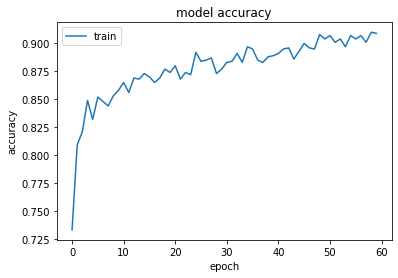

In [236]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

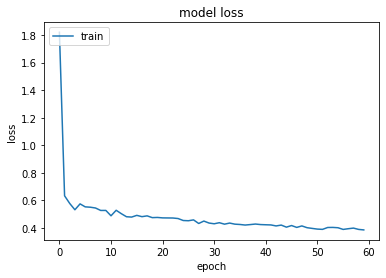

In [237]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# Test

In [238]:
_, acc = cnn.evaluate(test_data, test_labels, verbose = False)

print('Accuracy = %.2f' % (acc*100) + '%')

Accuracy = 89.46%
